<a href="https://colab.research.google.com/github/AshishRaj04/makemore/blob/main/makemore_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problems**
- last time we only had one character of context , i.e; 2D space
- the prediction was not so good because of only one character of context.
- if we take 3 character of context (3D-space) the number of possible probabilities grow exponentially 27x27x27.
- Curse of dimensionality

**Solution**
- Modeling approach : *[Bengio et al. 2003 MLP language model paper](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)*
- vocab: 17000 , association each word in vocab in a let's say 30 dim space as feature vectors . They were initiallized randomly . Then tuned using backpropagation , so that words having similar meaning goes to similar space.
- Through the embedding space you can transfer knowledge that both 'cat' and 'dog' are followed by 'is'.

In [1]:
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# code to save the figures and plots

IMAGES_PATH = Path() / "results"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
seed = tf.random.set_seed(4224444)

In [4]:
data_path = "/content/drive/MyDrive/Projects/ building makemore part 1/names.txt"

In [5]:
with open(data_path, 'r') as f:
  names = f.read().splitlines()

In [6]:
len(names)

32033

In [7]:
chars = sorted(list(set("".join(names))))
str_to_idx = {s : i+1 for i,s in enumerate(chars)}
str_to_idx['.'] = 0
idx_to_str = {i:s for s,i in str_to_idx.items()}

In [8]:
print(idx_to_str)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


# Data for traning

In [9]:
block_size = 4 # size of the context length : how many character do we take to predict the next one ?

X , Y = [] , []

for name in names:
  # print(name)
  context = [0] * block_size
  for ch in name + '.':
    ix = str_to_idx[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(idx_to_str[i] for i in context), '--->', ch)
    context = context[1:] + [ix]


In [10]:
X = tf.Variable(tf.convert_to_tensor(X))
Y = tf.Variable(tf.convert_to_tensor(Y))

In [11]:
X.shape , Y.shape

(TensorShape([228146, 4]), TensorShape([228146]))

In [45]:
C = tf.Variable(tf.random.uniform(shape=(27 , 2) , seed=seed))

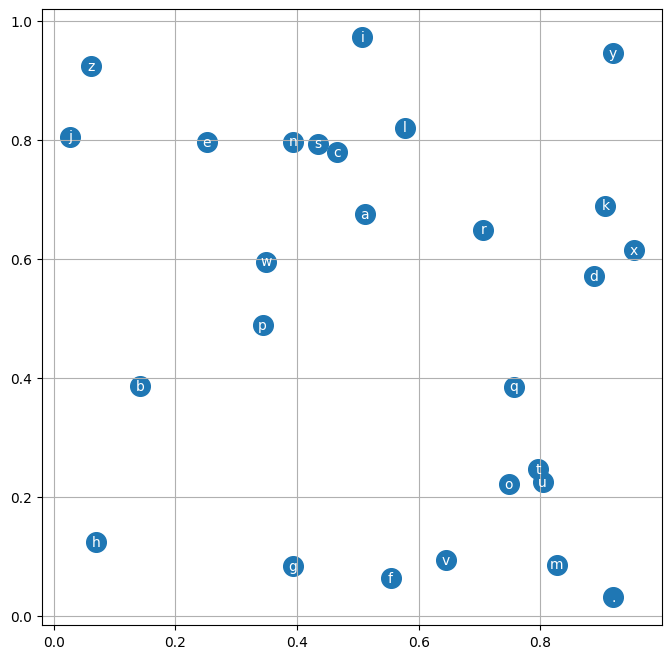

In [53]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].numpy(), C[:,1].numpy(), s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].numpy().item(), C[i,1].numpy().item(), idx_to_str[i], ha="center", va="center", color='white')
plt.grid('minor')
# plt.savefig('raw_emb.png')

# Intutive understanding

In [15]:
emb = tf.gather(C, X) # 25 different examples , each having 4 dims to explain the context , each being embedded in space with 2 dims
print(emb.shape)

(25, 4, 2)


In [16]:
initializer = tf.keras.initializers.GlorotNormal(seed=seed)
W1 = tf.Variable(initializer(shape=(8 , 150)), name="W")
b1 = tf.Variable(tf.random.uniform(shape = [150]), name="b")

In [18]:
# tf.concat([emb[ : , 0 , :] , emb[ : , 1 , :] ,  emb[ : , 2 , :] ,  emb[ : , 3 , :]] , axis = 1 ).shape
# tf.concat(tf.unstack(emb , axis=1) , axis = 1).shape
# tf.reshape(emb , shape=(25,8)).shape

In [17]:
h = tf.math.tanh((tf.reshape(emb , shape=(-1 , 8)) @ W1) + b1)
h.shape

TensorShape([25, 150])

In [18]:
W2 = tf.Variable(initializer(shape=(150 , 27)), name="W")
b2 = tf.Variable(tf.random.uniform(shape = [27]), name="b")

In [19]:
logits = h @ W2 + b2

In [20]:
logits.shape

TensorShape([25, 27])

In [21]:
counts = tf.math.exp(logits)
probs = counts / tf.reduce_sum(counts , axis=1 , keepdims=True)

- probs : for every sequence in X (25) , probabilities assigned to each character (27) , what might come next (prediction)
- for 0th idx we know its "e" that is idx 5 . tf.gather will pluck out the probability assigned to "e" (0.04334054) . and similarly to every other sequence in the traning data .
- this probability is not the highest as the nn is not trained.

In [22]:
indices = tf.stack([tf.range(tf.shape(X)[0]) , Y] , axis = 1)
probabilities = tf.gather_nd(probs, indices)

In [23]:
probabilities

<tf.Tensor: shape=(25,), dtype=float32, numpy=
array([0.0122228 , 0.01001852, 0.00823515, 0.03289492, 0.01034561,
       0.00962095, 0.02149989, 0.04419374, 0.02224802, 0.04205625,
       0.02920678, 0.01205226, 0.03062414, 0.0208989 , 0.03218884,
       0.01169239, 0.04550154, 0.0966335 , 0.03000297, 0.02960395,
       0.01772849, 0.0145019 , 0.01571724, 0.03445022, 0.00958705],
      dtype=float32)>

In [24]:
loss = tf.reduce_mean(-tf.math.log(probabilities))

In [25]:
loss

<tf.Tensor: shape=(), dtype=float32, numpy=3.8579320907592773>

In [26]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
Y_reshaped = tf.reshape(Y, [-1])
loss_fn(Y_reshaped, logits)

<tf.Tensor: shape=(), dtype=float32, numpy=3.8579320907592773>

- always use tf loss function when building large nn
- here both loss are same
- but in case of SparseCategoricalCrossentropy , forward pass , backpropagation will be much efficient and things will be numerically stable

# Neural Network Setup

In [54]:
block_size = 4 # size of the context length : how many character do we take to predict the next one ?

def build_dataset(names):

  X , Y = [] , []

  for name in names:
    # print(name)
    context = [0] * block_size
    for ch in name + '.':
      ix = str_to_idx[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(idx_to_str[i] for i in context), '--->', ch)
      context = context[1:] + [ix]
  X = tf.Variable(tf.convert_to_tensor(X))
  Y = tf.Variable(tf.convert_to_tensor(Y))
  print(X.shape, Y.shape)
  return X, Y



In [55]:
import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

Xtr, Ytr = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xte, Yte = build_dataset(names[n2:])

(182580, 4) (182580,)
(22767, 4) (22767,)
(22799, 4) (22799,)


In [56]:
C = tf.Variable(tf.random.uniform(shape=(27 , 2) , seed=seed))

In [57]:
initializer = tf.keras.initializers.GlorotNormal(seed=seed)
W1 = tf.Variable(initializer(shape=(8 , 150)), name="W")
b1 = tf.Variable(tf.random.uniform(shape = [150]), name="b")

In [58]:
W2 = tf.Variable(initializer(shape=(150 , 27)), name="W")
b2 = tf.Variable(tf.random.uniform(shape = [27]), name="b")

In [59]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [60]:
parameters = [C , W1 , b1 , W2 , b2]

In [61]:
for p in parameters:
  total_elements = tf.size(p).numpy()
  print(f"Parameter: {p.name}, Total elements: {total_elements}")

Parameter: Variable:0, Total elements: 54
Parameter: W:0, Total elements: 1200
Parameter: b:0, Total elements: 150
Parameter: W:0, Total elements: 4050
Parameter: b:0, Total elements: 27


In [62]:
num_epochs = 600
learning_rate = 0.01
losses = []
# Instantiate the Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        # Forward pass:
        emb = tf.gather(C,Xtr) # [batch, block_size, embedding_dim]
        h = tf.math.tanh((tf.reshape(emb , shape=(-1 , 8)) @ W1) + b1)
        logits = h @ W2 + b2
        loss = loss_fn(tf.reshape(Ytr, [-1]), logits)


    # Compute the gradients with respect to parameters
    grads = tape.gradient(loss, parameters)

    # Update parameters using the Adam optimizer
    optimizer.apply_gradients(zip(grads, parameters))

    losses.append(loss.numpy())

    if epoch % 30 == 0:
      print(f"epoch={epoch}, loss={loss.numpy():.4f}")

epoch=0, loss=3.6542
epoch=30, loss=2.4423
epoch=60, loss=2.4084
epoch=90, loss=2.3686
epoch=120, loss=2.3256
epoch=150, loss=2.2950
epoch=180, loss=2.2691
epoch=210, loss=2.2471
epoch=240, loss=2.2299
epoch=270, loss=2.2143
epoch=300, loss=2.2034
epoch=330, loss=2.1883
epoch=360, loss=2.1805
epoch=390, loss=2.1694
epoch=420, loss=2.1624
epoch=450, loss=2.1562
epoch=480, loss=2.1508
epoch=510, loss=2.1463
epoch=540, loss=2.1421
epoch=570, loss=2.1369


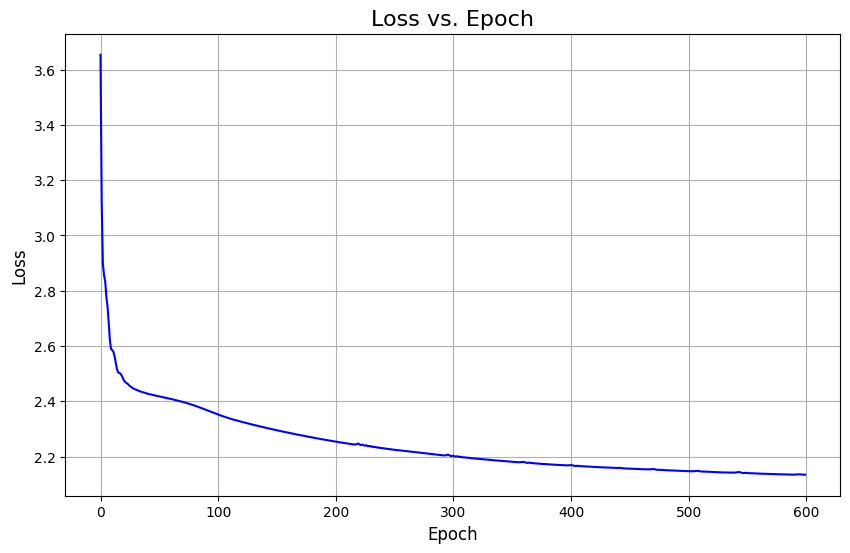

In [64]:
plt.figure(figsize=(10, 6))
plt.plot(losses, linestyle='-', color='b')
plt.title('Loss vs. Epoch', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True)
# plt.savefig('loss_vs_epoch.png')
plt.show()

traning loss

In [65]:
emb = tf.gather(C,Xtr) # [batch, block_size, embedding_dim]
h = tf.math.tanh((tf.reshape(emb , shape=(-1 , 8)) @ W1) + b1)
logits = h @ W2 + b2
loss = loss_fn(tf.reshape(Ytr, [-1]), logits)
loss

<tf.Tensor: shape=(), dtype=float32, numpy=2.133781671524048>

validation loss

In [66]:
emb = tf.gather(C,Xdev) # [batch, block_size, embedding_dim]
h = tf.math.tanh((tf.reshape(emb , shape=(-1 , 8)) @ W1) + b1)
logits = h @ W2 + b2
loss = loss_fn(tf.reshape(Ydev, [-1]), logits)
loss

<tf.Tensor: shape=(), dtype=float32, numpy=2.154500722885132>

so the validation loss and the traning losses are kinda equal and hense the model is not powerfull enough to memorise the traning data completely .
this means our model is weak as of now . we have to increase the model parameters and embedding dimensions

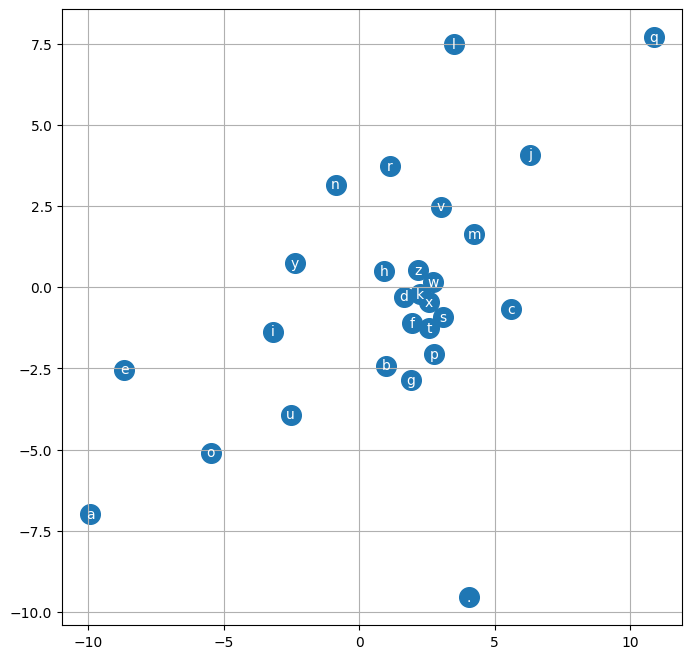

In [67]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].numpy(), C[:,1].numpy(), s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].numpy().item(), C[i,1].numpy().item(), idx_to_str[i], ha="center", va="center", color='white')
plt.grid('minor')
# plt.savefig('learned_emb.png')

## 🔍 What This Embedding Plot Shows
Each point is a 2D projection of a learned vector for one character (a-z). Based on your plot:

**✅ Semantically similar letters are clustering together**:
- Most characters are huddled in the middle (likely due to being more common in names).

- Letters like d, t, h, w, z, f, s are very close — which makes sense:

- These often appear in similar contexts (like ending or middle of names).

**🧠 Outliers are meaningful**:
- q, x, l, and j are further out — not super frequent in names and less interchangeable with other letters.

- a and e are spaced apart — possibly because:

- a is common as a prefix/suffix (e.g. anna, alex, etc.).

- e appears a lot but likely in different contexts (e.g. steve, george).

**🤔 Some characters may have a unique phonetic or positional role**:
- For example:

- l is often doubled (ll) in names like "Bella", "Will".

- q rarely occurs except with u, giving it a unique use pattern.

# Sampling from the model

In [71]:
block_size = 4
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = tf.gather(C , tf.constant([context] , dtype=tf.int32)) # (1,block_size,d)
      emb_flat = tf.reshape(emb, [1, -1])
      h = tf.math.tanh(tf.matmul(emb_flat, W1) + b1)
      logits = h @ W2 + b2
      probs = tf.nn.softmax(logits, axis=1)
      ix = tf.random.categorical(tf.math.log(probs), num_samples=1)[0, 0].numpy()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(idx_to_str[i] for i in out))

chubarae.
talay.
deom.
aman.
fery.
mathraehley.
ajacitaynadie.
kayse.
mayser.
pharley.
fyso.
camchevan.
athelie.
silolinn.
heiren.
kayann.
tray.
travi.
dermus.
gadriet.
